In [1]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION']='python'

import warnings
import tensorflow
import matplotlib.pyplot as plt
from IPython.display import clear_output

warnings.filterwarnings('ignore')

# Data Loading

In [3]:
train_data=tensorflow.keras.utils.image_dataset_from_directory(
    directory='Datasets/Breast Cancer/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256,256),
    shuffle=True
)

test_data=tensorflow.keras.utils.image_dataset_from_directory(
    directory='Datasets/Breast Cancer/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256,256),
)

Found 8000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


# Going through samples

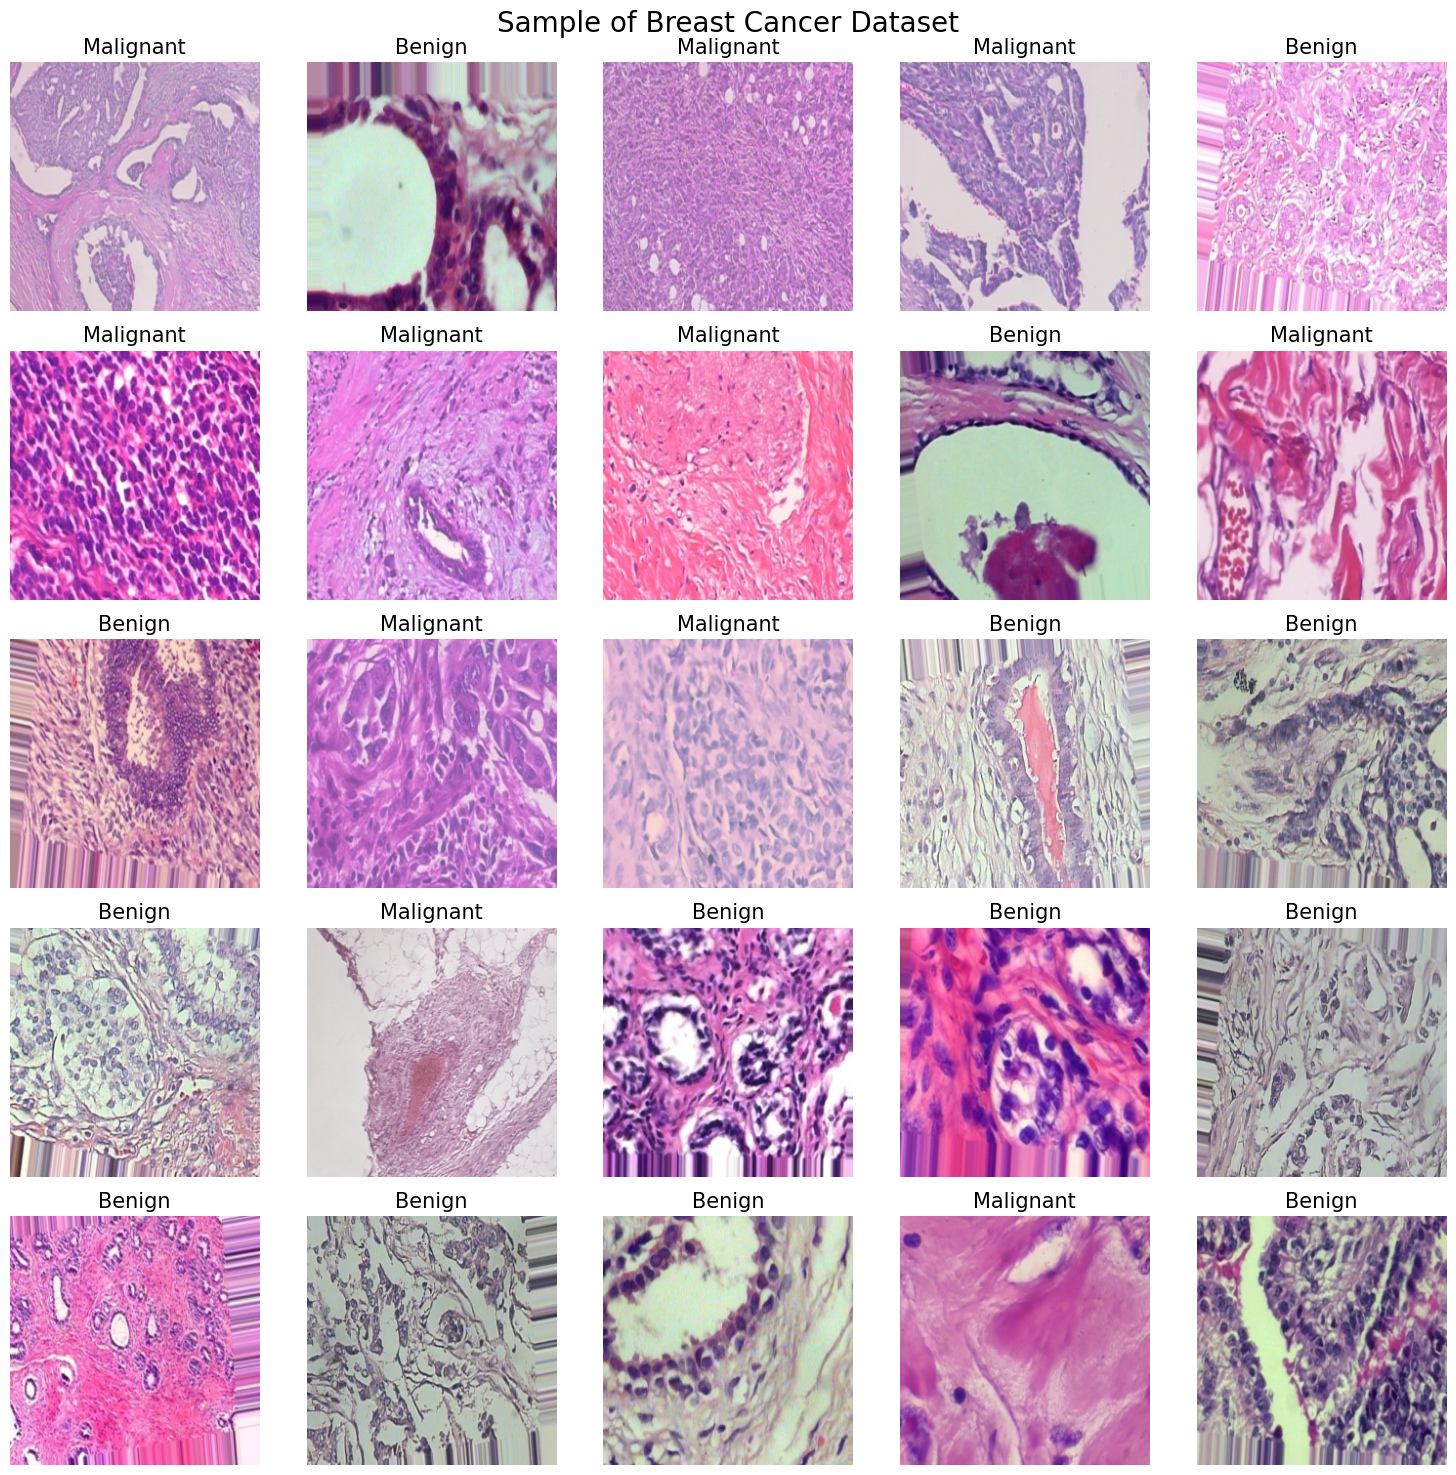

In [3]:
images,labels=next(iter(train_data))


plt.figure(figsize=(15,15))
plt.suptitle('Sample of Breast Cancer Dataset',fontsize=20,fontweight=18)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(f"{'Benign' if int(labels[i])==0 else 'Malignant'}",fontsize=15)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Building our own custom layers for Vision Transformer

In [4]:
#Feed Forward Network
class DenseLayer(tensorflow.keras.layers.Layer):
    def __init__(self,units,activation='linear',input_dim=None,**kwargs):
        if input_dim is not None:kwargs['input_shape']=(input_dim,)
        super().__init__(**kwargs)
        self.units=units
        self.activation=activation

    def build(self,input_shape):
        input_dim=input_shape[-1]
        self.W=self.add_weight(
            shape=(input_dim,self.units),
            initializer='glorot_uniform',
            trainable=True,
            name='W'
        )
        self.B=self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            trainable=True,
            name='B'
        )
        super().build(input_shape)

    def call(self,inputs,training=None):
        output=tensorflow.matmul(inputs,self.W)+self.B
        if self.activation=='sigmoid':return tensorflow.nn.sigmoid(output)
        if self.activation=='softmax':return tensorflow.nn.softmax(output,axis=-1)
        if self.activation=='relu':return tensorflow.nn.relu(output)
        if self.activation=='gelu':return tensorflow.nn.gelu(output)
        return output


#Multihead Attention with Rotary Positional Encoding
class MultiHeadAttention(tensorflow.keras.layers.Layer):
    def __init__(self,num_heads,d_model,H,W,dropout=0.0,**kwargs):
        super().__init__(**kwargs)
        self.num_heads=num_heads
        self.d_model=d_model
        self.H=H
        self.W=W
        self.dropout_rate=dropout
        self.head_dim=d_model//num_heads

        if self.head_dim % 4 != 0:
                raise ValueError(f"head_dim must be divisible by 4 for 2D RoPE, got {self.head_dim}")
        self.dropout=tensorflow.keras.layers.Dropout(dropout)

    def build(self,input_shape):
        
        self.WQ=self.add_weight(
            shape=(self.d_model,self.d_model),
            initializer='glorot_uniform',
            trainable=True,
            name='WQ'
        )
        self.WK=self.add_weight(
            shape=(self.d_model,self.d_model),
            initializer='glorot_uniform',
            trainable=True,
            name='WK'
        )
        self.WV=self.add_weight(
            shape=(self.d_model,self.d_model),
            initializer='glorot_uniform',
            trainable=True,
            name='WV'
        )
        self.WO=self.add_weight(
            shape=(self.d_model,self.d_model),
            initializer='glorot_uniform',
            trainable=True,
            name='WO'
        )
        super().build(input_shape)

    def build_2d_angles(self):
        head_dim=self.head_dim
        half=head_dim//2
        quarter=half//2

        row_pos=tensorflow.range(self.H,dtype=tensorflow.float32)[:,None]
        dim_idx=tensorflow.range(quarter,dtype=tensorflow.float32)[None,:]
        freq=1.0/tensorflow.pow(10000.0,dim_idx/float(quarter))
        angles_row=row_pos*freq

        sin_row=tensorflow.sin(angles_row)[None,None,:,None,:]
        cos_row=tensorflow.cos(angles_row)[None,None,:,None,:]

        col_pos=tensorflow.range(self.W,dtype=tensorflow.float32)[:,None]
        angles_col=col_pos*freq

        sin_col=tensorflow.sin(angles_col)[None,None,:,None,:]
        cos_col=tensorflow.cos(angles_col)[None,None,:,None,:]

        return sin_row,cos_row,sin_col,cos_col

    def apply_rotary(self,x,sin,cos):
        """
        X.shape=[...,2*quarter],
        sin,cos should broadcastable to x
        """
        last_dim=tensorflow.shape(x)[-1]
        half_dim=last_dim//2
        x1=x[...,:half_dim]
        x2=x[...,half_dim:]

        x_rot1=x1*cos-x2*sin
        x_rot2=x1*sin+x2*cos

        return tensorflow.concat([x_rot1,x_rot2],axis=-1)
        

    def call(self,x,training=None):
        # x:(batch,seq_len,d_model) where seq_len=1+H*W(CLS+patches)
        batch_size=tensorflow.shape(x)[0]
        seq_len=tensorflow.shape(x)[1]

        Q=tensorflow.matmul(x,self.WQ)
        K=tensorflow.matmul(x,self.WK)
        V=tensorflow.matmul(x,self.WV)

        Q=tensorflow.reshape(Q,[batch_size,seq_len,self.num_heads,self.head_dim])
        K=tensorflow.reshape(K,[batch_size,seq_len,self.num_heads,self.head_dim])
        V=tensorflow.reshape(V,[batch_size,seq_len,self.num_heads,self.head_dim])

        Q=tensorflow.transpose(Q,perm=[0,2,1,3])
        K=tensorflow.transpose(K,perm=[0,2,1,3])
        V=tensorflow.transpose(V,perm=[0,2,1,3])

        #extracting cls
        cls_q=Q[:,:,:1,:]
        cls_k=K[:,:,:1,:]
        cls_v=V[:,:,:1,:]

        #extracting patch
        patch_q=Q[:,:,1:,:]
        patch_k=K[:,:,1:,:]
        patch_v=V[:,:,1:,:]

        H=self.H
        W=self.W
        patched_q=tensorflow.reshape(patch_q,[batch_size,self.num_heads,H,W,self.head_dim])
        patched_k=tensorflow.reshape(patch_k,[batch_size,self.num_heads,H,W,self.head_dim])

        #splitting head_dim into row/col half(like real and imaginary for in row and col)
        half=self.head_dim//2
        q_r=patched_q[...,:half]
        q_c=patched_q[...,half:]
        k_r=patched_k[...,:half]
        k_c=patched_k[...,half:]


        #building 2d rope angles
        sin_row,cos_row,sin_col,cos_col=self.build_2d_angles()

        #applying rope
        q_r_rot=self.apply_rotary(q_r,sin_row,cos_row)
        q_c_rot=self.apply_rotary(q_c,sin_col,cos_col)
        k_r_rot=self.apply_rotary(k_r,sin_row,cos_row)
        k_c_rot=self.apply_rotary(k_c,sin_col,cos_col)

        patched_q_rot=tensorflow.concat([q_r_rot,q_c_rot],axis=-1)
        patched_k_rot=tensorflow.concat([k_r_rot,k_c_rot],axis=-1)

        #reshaping before concatinating with cls again
        patched_q_rot=tensorflow.reshape(patched_q_rot,[batch_size,self.num_heads,H*W,self.head_dim])
        patched_k_rot=tensorflow.reshape(patched_k_rot,[batch_size,self.num_heads,H*W,self.head_dim])

        #recombining with cls
        q_full=tensorflow.concat([cls_q,patched_q_rot],axis=2)
        k_full=tensorflow.concat([cls_k,patched_k_rot],axis=2)

        #attention operation
        dk=tensorflow.cast(self.head_dim,tensorflow.float32)
        scores=tensorflow.matmul(q_full,k_full,transpose_b=True)/tensorflow.sqrt(dk)

        weights=tensorflow.nn.softmax(scores,axis=-1)
        weights=self.dropout(weights,training=training)

        attention=tensorflow.matmul(weights,tensorflow.concat([cls_v,patch_v],axis=2))

        #combine heads
        attention=tensorflow.transpose(attention,perm=[0,2,1,3])
        attention=tensorflow.reshape(attention,[batch_size,seq_len,self.d_model])

        output=tensorflow.matmul(attention,self.WO)
        return output

# Building Transformer

In [5]:
class TransformerEncoderBlock(tensorflow.keras.layers.Layer):
    def __init__(self,d_model,num_heads,H,W,mlp_ratio=4,dropout=0.1,**kwargs):
        super().__init__(**kwargs)
        self.norm1=tensorflow.keras.layers.LayerNormalization(epsilon=1e-6)
        self.attn=MultiHeadAttention(
            num_heads=num_heads,
            d_model=d_model,
            H=H,
            W=W,
            dropout=dropout
        )
        self.drop1=tensorflow.keras.layers.Dropout(dropout)
        self.norm2=tensorflow.keras.layers.LayerNormalization(epsilon=1e-6)
        self.mlp=tensorflow.keras.Sequential([
            DenseLayer(
                units=d_model*mlp_ratio,
                activation='gelu'
            ),
            tensorflow.keras.layers.Dropout(dropout),
            DenseLayer(units=d_model)
        ])
        self.drop2=tensorflow.keras.layers.Dropout(dropout)
        
    def call(self,x,training=None):
        h=self.norm1(x)
        h=self.attn(h,training=training)
        h=self.drop1(h,training=training)
        x=x+h

        h2=self.norm2(x)
        h2=self.mlp(h2,training=training)
        h2=self.drop2(h2,training=training)
        x=x+h2
        return x

class VisionTransformer(tensorflow.keras.Model):
    def __init__(self,
                 image_size=256,
                 patch_size=32,
                 d_model=256,
                 num_heads=8,
                 depth=4,
                 num_classes=2,
                 **kwargs
                ):
        super().__init__(**kwargs)
        assert image_size%patch_size==0
        self.image_size=image_size
        self.patch_size=patch_size
        self.d_model=d_model
        self.num_heads=num_heads
        self.depth=depth
        self.num_classes=num_classes

        self.H=image_size//patch_size
        self.W=image_size//patch_size
        self.num_patches=self.H*self.W #num_patches(seq_len)

        self.proj=DenseLayer(d_model)
        self.cls_token=self.add_weight(
            shape=(1,1,d_model),
            initializer=tensorflow.keras.initializers.Zeros(),
            trainable=True,
            name='cls_token'
        )
        self.pos_embed=self.add_weight(
            shape=(1,self.num_patches+1,d_model),
            initializer=tensorflow.keras.initializers.RandomNormal(stddev=0.02),
            trainable=True,
            name='pos_embed'
        )

        self.blocks=[
            TransformerEncoderBlock(d_model,num_heads,self.H,self.W,name=f"enc_block_{i}")
            for i in range(depth)
        ]
        self.norm=tensorflow.keras.layers.LayerNormalization(epsilon=1e-6)
        self.head=DenseLayer(num_classes)

    def patchify(self,images):
        batch_size=tensorflow.shape(images)[0]
        patches=tensorflow.image.extract_patches(
            images=images,
            sizes=[1,self.patch_size,self.patch_size,1],
            strides=[1,self.patch_size,self.patch_size,1],
            rates=[1,1,1,1],
            padding='VALID'
        )
        patch_dim=self.patch_size*self.patch_size*3
        patches=tensorflow.reshape(patches,[batch_size,-1,patch_dim])
        return patches

    def call(self,images,training=None):
        batch_size=tensorflow.shape(images)[0]
        x=self.patchify(images)
        x=self.proj(x)

        cls=tensorflow.tile(self.cls_token,[batch_size,1,1])
        x=tensorflow.concat([cls,x],axis=1)
        x=x+self.pos_embed

        for blk in self.blocks:
            x=blk(x,training=training)

        x=self.norm(x)
        cls_out=x[:,0]
        logits=self.head(cls_out)
        return logits

# Training Custom ViT

In [6]:
inputs = tensorflow.keras.Input(shape=(256, 256, 3))
x = tensorflow.keras.layers.Rescaling(1.0/255)(inputs)

vit = VisionTransformer(
    image_size=256,
    patch_size=32,
    d_model=256,
    num_heads=8,
    depth=6,
    num_classes=2,
)(x)

model = tensorflow.keras.Model(inputs, vit)

model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(3e-4),
    loss=tensorflow.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [7]:
history=model.fit(
    train_data,
    epochs=40,
    validation_data=test_data,
    callbacks=[
        tensorflow.keras.callbacks.ModelCheckpoint(
            'vit_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        tensorflow.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            verbose=1,
            restore_best_weights=False
        ),
        tensorflow.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3,
            verbose=1,
            factor=0.5
        )
    ],
    verbose=2
)

model.load_weights('vit_best.weights.h5')
print("✓ Best ViT weights loaded")

Epoch 1/40


I0000 00:00:1763551770.135706      63 service.cc:148] XLA service 0x7a82dc212fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763551770.136642      63 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763551773.337238      63 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763551790.446224      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_accuracy improved from -inf to 0.61600, saving model to vit_best.weights.h5
250/250 - 92s - 366ms/step - accuracy: 0.6431 - loss: 0.6896 - val_accuracy: 0.6160 - val_loss: 0.6471 - learning_rate: 3.0000e-04
Epoch 2/40

Epoch 2: val_accuracy improved from 0.61600 to 0.78050, saving model to vit_best.weights.h5
250/250 - 20s - 80ms/step - accuracy: 0.7778 - loss: 0.4849 - val_accuracy: 0.7805 - val_loss: 0.4970 - learning_rate: 3.0000e-04
Epoch 3/40

Epoch 3: val_accuracy improved from 0.78050 to 0.80950, saving model to vit_best.weights.h5
250/250 - 20s - 79ms/step - accuracy: 0.8030 - loss: 0.4351 - val_accuracy: 0.8095 - val_loss: 0.4445 - learning_rate: 3.0000e-04
Epoch 4/40

Epoch 4: val_accuracy improved from 0.80950 to 0.81200, saving model to vit_best.weights.h5
250/250 - 20s - 80ms/step - accuracy: 0.8124 - loss: 0.4288 - val_accuracy: 0.8120 - val_loss: 0.4147 - learning_rate: 3.0000e-04
Epoch 5/40

Epoch 5: val_accuracy did not improve from 0.81200
250/250 - 19s 

# Building Custom CNN

In [8]:
custom_cnn=tensorflow.keras.Sequential([
    tensorflow.keras.layers.Rescaling(1.0/255),
    tensorflow.keras.layers.Conv2D(32,kernel_size=(3,3),padding='same',activation='relu',input_shape=(256,256,3)),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2,padding='same'),

    tensorflow.keras.layers.Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2,padding='same'),

    tensorflow.keras.layers.Conv2D(128,kernel_size=(3,3),padding='same',activation='relu'),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2,padding='same'),

    tensorflow.keras.layers.GlobalAveragePooling2D(),

    tensorflow.keras.layers.Dense(64,activation='relu'),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.Dropout(0.3),

    
    tensorflow.keras.layers.Dense(32,activation='relu'),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.Dropout(0.1),

    tensorflow.keras.layers.Dense(1,activation='sigmoid')
    
])


In [9]:
custom_cnn.compile(
    optimizer=tensorflow.keras.optimizers.AdamW(learning_rate=1e-3,weight_decay=0.01),
    loss=tensorflow.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history2=custom_cnn.fit(
    train_data,
    validation_data=test_data,
    epochs=10,
    verbose=2,
    callbacks=[
        tensorflow.keras.callbacks.ModelCheckpoint(
            'cnn_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        tensorflow.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            verbose=1,
            restore_best_weights=False
        ),
        tensorflow.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3,
            verbose=1,
            factor=0.2
        )
    ]
)

custom_cnn.load_weights('cnn_best.weights.h5')
print("✓ Best CNN weights loaded")

Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to cnn_best.weights.h5
250/250 - 35s - 139ms/step - accuracy: 0.8649 - loss: 0.3099 - val_accuracy: 0.5000 - val_loss: 2.3049 - learning_rate: 0.0010
Epoch 2/10

Epoch 2: val_accuracy improved from 0.50000 to 0.64100, saving model to cnn_best.weights.h5
250/250 - 20s - 81ms/step - accuracy: 0.9120 - loss: 0.2192 - val_accuracy: 0.6410 - val_loss: 1.2597 - learning_rate: 0.0010
Epoch 3/10

Epoch 3: val_accuracy improved from 0.64100 to 0.79000, saving model to cnn_best.weights.h5
250/250 - 20s - 81ms/step - accuracy: 0.9334 - loss: 0.1683 - val_accuracy: 0.7900 - val_loss: 0.7046 - learning_rate: 0.0010
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.79000
250/250 - 20s - 81ms/step - accuracy: 0.9433 - loss: 0.1436 - val_accuracy: 0.7435 - val_loss: 0.9419 - learning_rate: 0.0010
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.79000
250/250 - 20s - 80ms/step - accuracy: 0.9575 - loss: 0.1132 

In [10]:
clear_output(wait=True)

# Performance Analysis

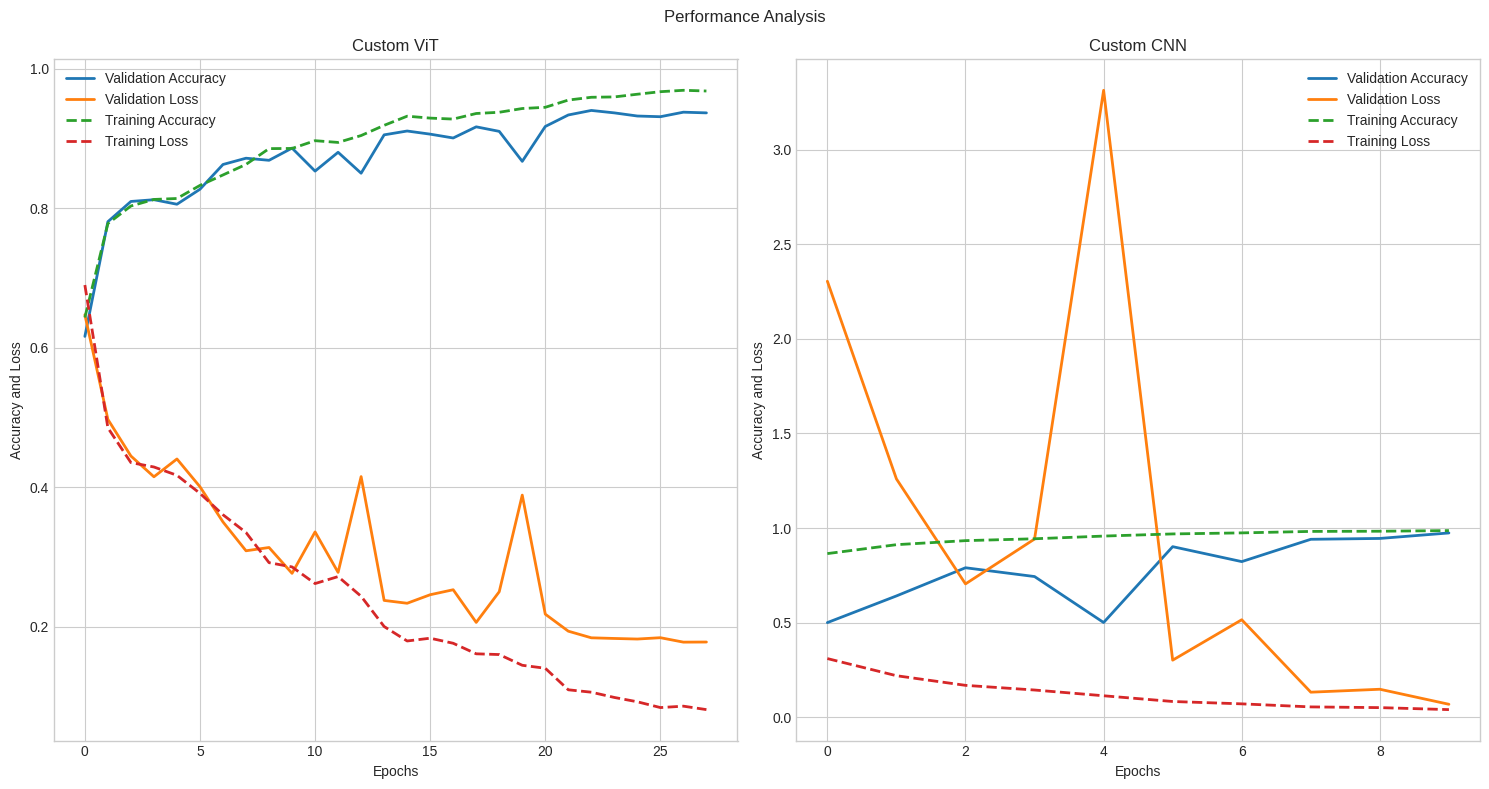


✓ Training complete! Plot saved as 'training_comparison.png'
ViT Final Val Accuracy: 0.9365
CNN Final Val Accuracy: 0.9740


In [11]:
plt.style.use("seaborn-v0_8-whitegrid")
fig,axes=plt.subplots(1,2,figsize=(15,8))
fig.suptitle('Performance Analysis')
axes[0].plot(history.history['val_accuracy'],linewidth=2,label='Validation Accuracy')
axes[0].plot(history.history['val_loss'],linewidth=2,label='Validation Loss')
axes[0].plot(history.history['accuracy'],linewidth=2,linestyle='--',label='Training Accuracy')
axes[0].plot(history.history['loss'],linewidth=2,linestyle='--',label='Training Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy and Loss')
axes[0].set_title('Custom ViT')
axes[0].legend()


axes[1].plot(history2.history['val_accuracy'],linewidth=2,label='Validation Accuracy')
axes[1].plot(history2.history['val_loss'],linewidth=2,label='Validation Loss')
axes[1].plot(history2.history['accuracy'],linewidth=2,linestyle='--',label='Training Accuracy')
axes[1].plot(history2.history['loss'],linewidth=2,linestyle='--',label='Training Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy and Loss')
axes[1].set_title('Custom CNN')
axes[1].legend()

fig.tight_layout()
plt.savefig('training_comparison.png',dpi=100,bbox_inches='tight')
plt.show()

print("\n✓ Training complete! Plot saved as 'training_comparison.png'")
print(f"ViT Final Val Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"CNN Final Val Accuracy: {history2.history['val_accuracy'][-1]:.4f}")